In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
name_of_file='bank_churn_modeling.csv'
path = '/content/gdrive/My Drive/Colab Notebooks/bank_churn_modeling.csv'

In [ ]:
import pandas as pd 

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv(path, 
                 sep=",", 
                 skiprows=0, 
             engine='python')

print (df)

      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMemb

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.corr().style.background_gradient("Blues")

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.006495,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.006495,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df1 = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
df['Geography'].head()

0    France
1     Spain
2    France
3    France
4     Spain
Name: Geography, dtype: object

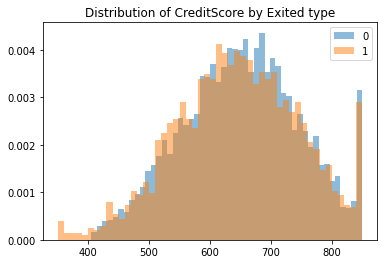

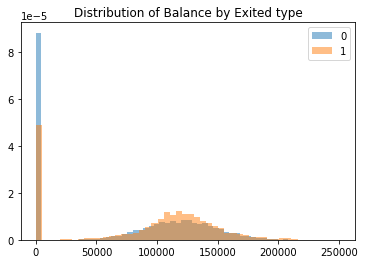

In [ ]:
import scipy.stats as stats
import numpy as np

for col in ['CreditScore', 'Balance']:
  for flag in [0,1]:
    temp = df[df.Exited == flag]
    plt.title(f'Distribution of {col} by Exited type')
    fit = stats.norm.pdf(temp[col])
    plt.hist(temp[col], 50, density=True, label=flag, alpha = 0.5, lw=3);
    plt.legend();
  plt.show()

# Churn exploratory analysis

In [ ]:
import plotly.express as px
target_instance = df1["Exited"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
fig = px.pie(target_instance, values='Exited', names='Category', color_discrete_sequence=["green", "red"],
             title='Distribution of Churn')
fig.show()

In [ ]:
#Defining bar chart function
def bar(feature, df=df1 ):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Exited']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str


    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)
    
    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Exited', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["green", "red"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )
     
    return fig.show()

In [ ]:
#Gender feature plot
bar('Gender')

In [ ]:
df2 = df1.drop(['Geography','Gender'], axis=1)

In [ ]:
Geography = pd.get_dummies(df.Geography).iloc[:,1:]
Gender = pd.get_dummies(df.Gender).iloc[:,1:]

In [ ]:
df_fin = pd.concat([df2,Geography ,Gender], axis=1)

In [ ]:
X = df_fin.drop(['Exited'], axis=1)
y = df_fin['Exited']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1) 
clf.fit(X_train, y_train)
predictions = classifier.predict(X_test)

0:	learn: 0.6435775	total: 49.3ms	remaining: 197ms
1:	learn: 0.6046034	total: 51.9ms	remaining: 77.8ms
2:	learn: 0.5713934	total: 54.2ms	remaining: 36.2ms
3:	learn: 0.5415994	total: 56.6ms	remaining: 14.2ms
4:	learn: 0.5196212	total: 58.9ms	remaining: 0us


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predictions ))
print(accuracy_score(y_test, predictions ))



              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.75      0.52      0.61       405

    accuracy                           0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000

0.8675


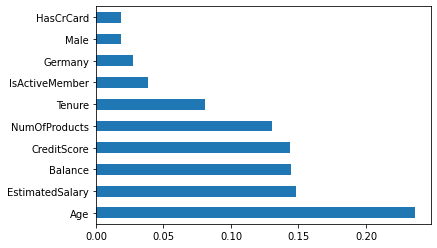

In [ ]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest (10).plot (kind='barh')